In [1]:
EXPORT_LATEX = False

%matplotlib inline 
# %matplotlib notebook would provide interactive plots

import glob
import csv
from os import path

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib2tikz import save as _tikz_save

pd.set_option('display.precision', 3,
              'display.width', 300)

PATH_ROOT = '../matlab/mainczjs/evaluation/results/'
PATH_LATEX_PLOTS = '../latex/data/plots/'
PATH_LATEX_TABLES = '../latex/data/tables/'

NAME_FOLDER = "fixed-em-iterations-5"
NAME_EVALUATION = NAME_FOLDER
NAME_DATA_FILES = '*results.txt'
NAME_DATAFRAME = NAME_EVALUATION+'.pkl'

NAME_SCATTER_PLOT = NAME_EVALUATION+'-scatter.tex'
NAME_BOX_PLOT = NAME_EVALUATION+'-box.tex'
NAME_BAR_PLOT = NAME_EVALUATION+'-bar.tex'
NAME_SUMMARY_TABLE = NAME_EVALUATION+'-summary.tex'
NAME_PERFECT_MATCHES_PLOT = NAME_EVALUATION+'-perfect-matches-bar.tex'
PATH_SCATTER_PLOT = path.join(PATH_LATEX_PLOTS, NAME_SCATTER_PLOT)
PATH_BOX_PLOT = path.join(PATH_LATEX_PLOTS, NAME_BOX_PLOT)
PATH_BAR_PLOT = path.join(PATH_LATEX_PLOTS, NAME_BAR_PLOT)
PATH_LATEX_SUMMARY_TABLE = path.join(PATH_LATEX_TABLES, NAME_SUMMARY_TABLE)

lms_red = (204/255, 53/255, 56/255)

DICT_SUMMARY = {'x1':'count',  # sample size
                'em':np.mean,  # em-iterations
                'T60':np.mean,
                'SNR':np.mean,
                'err_mean':np.mean,
                'perfect_match':np.mean}

DEFAULT_LINE_PLOT_ARGS = {'kind':'line',
                          'marker':'o',
                          'color':[lms_red, "darkgray", "lightgray", "orange", "black"]}

def _get_trial_index(t):
    return ["t{}".format(i+1) for i in range(t)]

def _get_col_name(s,post):
    return sum([("x{}{},y{}{}".format(n,post,n,post)).split(',') for n in range(1,s+1)],[])

def _get_err_col_name(s):
    return ["err{}".format(n) for n in range(1,s+1)]

def get_col_names(s):
    return sum([_get_col_name(s,""), _get_col_name(s,"est"), _get_err_col_name(s)], []) 

def is_x1_correct(row):
    if abs(row["x1"]-row["x1est"]) > 0.001:
        if abs(row["y1"]-row["y1est"]) > 0.001:
            return 1
    return 0

def tikz_save(*args, **kwargs):
    """Wrapper for tikz_save function, that always suppresses additional info output"""
    kwargs['show_info'] = False 
    _tikz_save(*args, **kwargs)

def adjust_y_axis(step_size, digits=0, min=None):
    start, end = plt.axes().get_ylim()
    if min==None: min=start
    plt.yticks(np.arange(min, round(end+step_size, digits), step_size))

def scatter_plot(df, xaxis='n_sources', yaxis='err_mean'):
    x = df[xaxis].values
    y = df[yaxis].values
    means = df.groupby([xaxis]).mean()[yaxis]
    medians = df.groupby([xaxis]).median()[yaxis]
    plt.scatter(x, y, alpha=0.1, c="gray")
    plt.scatter(means.index.values, means.values, alpha=1.0, c=lms_red, marker="o", linewidth="4", label="mean")
    plt.scatter(medians.index.values, medians.values, alpha=1.0, c="black", marker="_", linewidth="2", label="median")
    # plt.xticks(n_sources_range)
    adjust_y_axis(step_size=0.5, digits=2, min=0)
    plt.grid(True, axis='y')
    plt.xlabel("number of sources")
    plt.ylabel("mean localisation error (m)")
    l = plt.legend()
    if EXPORT_LATEX:
        tikz_save(PATH_SCATTER_PLOT, show_info=False)

def style_boxplot(boxplots, fig=None, axes=None):
    if not type(boxplots)==type([]): boxplots=[boxplots]
    if not fig: fig = boxplots[0][0].ax.get_figure()
    if not axes: axes = [boxplots[0][0].ax]
    for bp in boxplots:
        for key in bp[0].lines.keys():
            for item in bp[0].lines[key]:
                if key=="fliers":
                    item.set_markerfacecolor("lightgray")
                    item.set_markeredgewidth(0)
                    item.set_markeredgecolor(lms_red)
                    item.set_markersize(7)
                if key=="medians":
                    item.set_color(lms_red)
                    item.set_linewidth(3)
                if key=="whiskers" or key=="caps":
                    item.set_color("gray")
                else:
                    item.set_color(lms_red)
    if axes:
        for ax in axes:
            ax.set_title("")
            ax.set_xlabel("number of sources")
            ax.set_ylabel("mean localisation error (m)")
            ax.grid(axis="x")
    if fig:
        fig.suptitle('')

def style_line_plot(xlabel, ylabel, grid):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis=grid)

def print_summary(df):
    print(df.description[1].upper()+":")
    summary = df.groupby('n_sources').agg(DICT_SUMMARY).rename(columns={'x1':'n', 'em':'em-iterations'})
    print(summary.transpose())
    for col in ['T60', 'em', 'SNR']:  # Print additional notes for these columns
        if df[col].min()!=df[col].max():
            col_values = df.pivot_table("x1", index=[col], columns=["n_sources"], aggfunc="count")
            if col_values.min().min()==col_values.max().max():
                n=col_values.min().min()
            else:
                if (col_values.min(axis=1).values-col_values.max(axis=1)).sum() == 0:
                    n = col_values.min(axis=1).values
                else:
                    print("WARN: Unbalanced n_sources for {}".format(col))
                    n="?"
            print("NOTE: Data contains range of {col} ({values}, n={n})".format(col=col, values=col_values.index.values, n=n))
    print()  # empty line at the end
            
def parse_parameters(fname):
    done=False
    s=0
    ret = {}
    while not done:
        i = fname.find("_", s)
        i2 = fname.find("_", i+1)
        s=i2
        if i < 0 or i2 < 0:
            done=True
            break
        else:
            fname_slice = fname[i+1:i2]
            name, value = fname_slice.split("=", 1)
            ret[name]=value
    return ret
        
def matlab2pandas(dirname=NAME_FOLDER, filename=NAME_DATA_FILES, save_to=None, summary=False):
    files = glob.glob(path.join(PATH_ROOT,dirname,filename))
    dfs = []
    
    # read data
    for f in files:
        # look at filename
        fname = f.split(sep="/")[-1]
        params = parse_parameters(fname)
        n_sources = int(params["s"])
        # prepare DataFrame
        df = pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float)
        df.drop(df.columns[[n_sources*4+n_sources]], axis=1, inplace=True) # drops empty column
        df.columns = get_col_names(n_sources)
        df.index = ["t{}".format(i+1) for i in range(len(df))]
        for key, value in params.items():
            df[key] = np.float(value)
        df["description"] = dirname
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    
    # edit data
    df.rename(columns={'s':'n_sources'}, inplace=True)
    df['SNR'] = df['SNR'].apply(int)
    df['em'] = df['em'].apply(int)
    df['n_sources'] = df['n_sources'].apply(int)
    df["err_mean"]      = df.loc[:, "err1":_get_err_col_name(n_sources)[-1]].mean(axis=1)
    df["err_total"]     = df.loc[:, "err1":_get_err_col_name(n_sources)[-1]].sum(axis=1)
    df["perfect_match"] = df["err_total"]<=0.01
    
    if summary:
        print_summary(df)

    if save_to: 
        df.to_pickle(save_to+".pkl")

    return df

## Custom Boxplot with Lines 

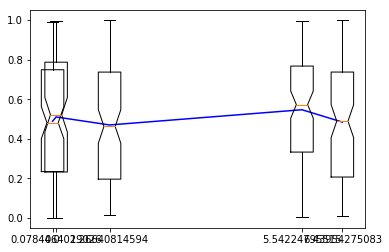

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data...
data = np.random.random((100, 5))
y = data.mean(axis=0)
x = np.random.random(y.size) * 10
x -= x.min()
x.sort()

# Plot a line between the means of each dataset
plt.plot(x, y, 'b-')

# Save the default tick positions, so we can reset them...
locs, labels = plt.xticks() 

plt.boxplot(data, positions=x, notch=True)

# Reset the xtick locations.
#plt.xticks(locs)
plt.show()

## Old way of reading data

In [ ]:
# Configuration

# NAME_EVALUATION = 'mean-err-n-sources'
# NAME_FOLDER = "{}sources"
# NAME_DATA_FILES = '2017-10-04*.txt'  # 1st trials, original speech samples

# NAME_EVALUATION = 'mean-err-n-sources-sample3and5exchanged'
# NAME_FOLDER = "{}sources"
# NAME_DATA_FILES = '2017-10-11*.txt'  # 2nd trials, rearranged speech samples

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.0'
# NAME_FOLDER = "{}sources-rnd"
# NAME_DATA_FILES = '2017-*results.txt'  # 3rd trials, BASE

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.3'
# NAME_FOLDER = "{}sources-rnd-T60"
# NAME_DATA_FILES = '2017-*0.3T60*results.txt'  # 4th trials, T60=0.3

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.6-em=5'
# NAME_FOLDER = "{}sources-rnd-T60"
# NAME_DATA_FILES = '2017-*0.6T60*5em_results.txt'  # 5th trials, T60=0.6, em=5

# NAME_EVALUATION = 'mean-err-n-sources-rnd-T60=0.6-em=10'
# NAME_FOLDER = "{}sources-rnd-T60"
# NAME_DATA_FILES = '2017-*0.6T60*10em_results.txt'  # 6th trials, T60=0.6, em=10

# NAME_EVALUATION = 'mean-err-n-sources-rnd-estimates'
# NAME_FOLDER = "{}sources-rnd-estimates"
# NAME_DATA_FILES = '*results.txt'  # 7th trials, random estimates (benchmark)

In [ ]:
n_sources_range = [1, 2, 3, 4, 5, 6, 7]
results_dict = {}

for s in n_sources_range:
    # define filename format
    files = glob.glob(path.join(PATH_ROOT,NAME_FOLDER.format(s), NAME_DATA_FILES))

    # load data
    dfs = []
    for f in files:
        dfs.append(pd.DataFrame(list(csv.reader(open(f, 'r'), delimiter='\t')), dtype=float))
    try:   
        results = pd.concat(dfs)
    except ValueError:
        continue
    n_trials = len(results)
    n_sources = int((len(results.columns)-1)/5)
    results.drop(results.columns[[n_sources*4+n_sources]], axis=1, inplace=True) # drops empty column
    results.columns = get_col_names(n_sources)
    results.index = ["t{}".format(i+1) for i in range(n_trials)]
    results_dict['{}'.format(n_sources)] = results
    
    # calculate helper columns
    results['n_sources']     = n_sources
    results["err_mean"]      = results.loc[:, "err1":_get_err_col_name(s)[-1]].mean(axis=1)
    results["err_total"]     = results.loc[:, "err1":_get_err_col_name(s)[-1]].sum(axis=1)
    results["perfect_match"] = results["err_total"]<=0.01

try:   
    results = pd.concat(results_dict, ignore_index=True)
except ValueError:
    print("NO DATA FOUND!")

print("SUMMARY:")
summary = results.groupby('n_sources').agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).rename(columns={'x1':'sample size'})
print(summary.transpose())

# print("")
# print("COMPLETE DATA:")
# print(results.sample(5))
if EXPORT_RESULTS:
    results.to_pickle(path.join(PATH_ROOT, NAME_DATAFRAME))
if EXPORT_LATEX:
    summary.transpose().to_latex(PATH_LATEX_SUMMARY_TABLE, column_format="rrrrrrr", bold_rows=True)

## Old way of comparing

In [ ]:
files = glob.glob(path.join(PATH_ROOT, 'mean-err-n-sources-rnd-T60*-dataframe.pkl'))
files2 = glob.glob(path.join(PATH_ROOT, 'mean-err-n-sources-rnd-estimates-dataframe.pkl'))
from pprint import pprint
print("The following files match the criterion:")

dfs = []
for f in files:
    df = pd.read_pickle(f)
    fname = f.split(sep="/")[-1]
    print(fname)
    version = fname[fname.find("rnd-")+4:fname.find("-dataframe")]
    if version=="": version="latest"
    df["version"] = version
    dfs.append(df)

for f in files2:
    df = pd.read_pickle(f)
    fname = f.split(sep="/")[-1]
    print(fname)
    df["version"] = "random"
    dfs.append(df)

dfc = pd.concat(dfs, ignore_index=True)
print("\nSUMMARY:")
print(dfc.groupby(by=["version", "n_sources"]).agg({'x1':'count', 'err_mean':np.mean, 'perfect_match':np.mean}).rename(columns={'x1':'sample size'}))

## Plot with groups 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import groupby

def test_table():
    data_table = pd.DataFrame({'version':['v1']*4 + ['v2']*4,
                               'n_sources':(['2']*2 + ['3']*2)*2,
                               'Quantity':[10,20,5,6,4,7,2,1],
                               'Ordered':np.random.randint(0,10,8)
                               })
    return data_table

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

df = dfc.groupby(['n_sources','version']).mean()["err_mean"]
fig = plt.figure(figsize=(17,5))
ax = fig.add_subplot(111)
df.plot(kind='bar',stacked=False,ax=fig.gca(),color=[lms_red,'black', 'gray'])
#Below 3 lines remove default labels
labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
label_group_bar_table(ax, df)
fig.subplots_adjust(bottom=.1*df.index.nlevels)

NameError: name 'dfc' is not defined

## Check for Normality (Q-Q-Plot)

GUESSING-AT-RANDOM:
n_sources          2      3      4      5      6      7
n                500    500    500    500    500    500
em-iterations      0      0      0      0      0      0
T60                0      0      0      0      0      0
SNR                0      0      0      0      0      0
err_mean        1.68   1.54   1.42   1.36   1.26   1.23
perfect_match  False  False  False  False  False  False

BASE:
n_sources            2        3        4        5        6        7
n              100.000  100.000  100.000  100.000  100.000  100.000
em-iterations   10.000   10.000   10.000   10.000   10.000   10.000
T60              0.000    0.000    0.000    0.000    0.000    0.000
SNR              0.000    0.000    0.000    0.000    0.000    0.000
err_mean         0.035    0.023    0.137    0.157    0.255    0.329
perfect_match    0.930    0.860    0.620    0.440    0.270    0.190



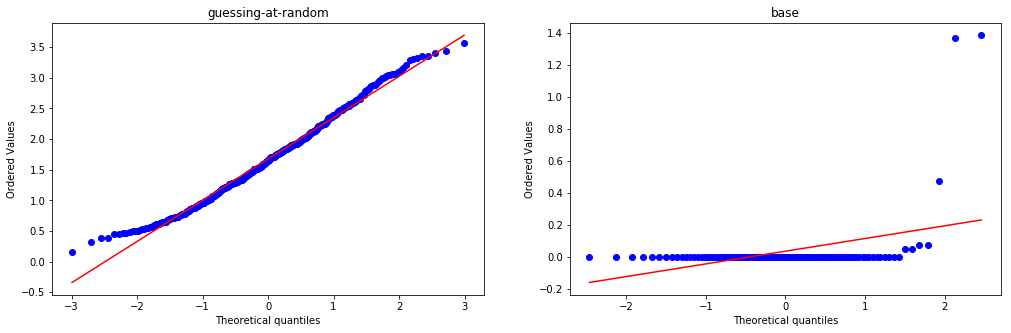

In [69]:
import pylab 
import numpy as np
import scipy.stats as stats

def transform(x):
    return np.power(x, -1)

evalruns = ['guessing-at-random', 'base']

pylab.subplots(1,2,figsize=(17, 5))
for desc in evalruns:
    df = matlab2pandas(dirname=desc, save_to=False, summary=True)
    df["err_mean"] = pd.to_numeric(df["err_mean"])
    df_s = df[df["n_sources"]==2]
    pylab.subplot(1,2,evalruns.index(desc)+1)
    stats.probplot(df_s["err_mean"], dist="norm", plot=pylab)
    pylab.title(desc)

pylab.show()